In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
import pandas as pd

from numpy import exp

from tracking.motion import ConstantVelocityModel, constant_velocity_models
from tracking.target import ConstantAccelerationTarget, ConstantVelocityTarget, SinusTarget, SingerTarget
from tracking.kalman import kalman_pv
from tracking.simulation import monte_carlo, rmse, execute, state_residuals

from tracking.plot import boxplot_rmse, aggregated_errors, plot_aggregated_errors, plot_error_band
from tracking.util import to_df

In [21]:
def simulate_kalman_2d(Q, n=100):
    t = 1
    
    x = np.zeros((2, 1))
    P = np.eye(2)
    R = np.eye(1)
    H = np.array([[1, 0]])
    F = np.array([[1, t], [0, 1]])
    
    trace = []
    for true_x in range(n):
        # measurement
        z = np.random.normal(true_x, R)
    
        # forward-predict
        P = F @ P @ F.T + Q
        x = F @ x
    
        # update
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x_n = x + K @ (z - H @ x)
        P_n = P - K @ S @ K.T
    
        trace.append((x, P, x_n, P_n, K))

        x, P = x_n, P_n

    return trace

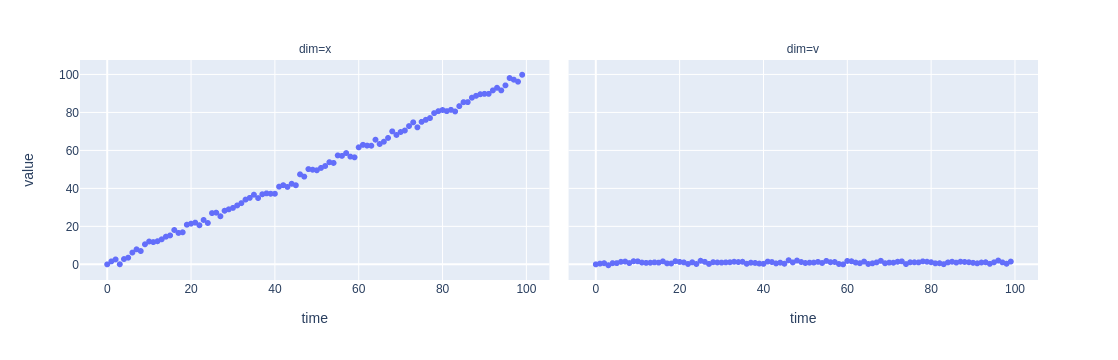

In [22]:
x_fwd = to_df(np.array([np.squeeze(x_fwd) for x_fwd, _, _, _, _ in simulate_kalman_2d(np.eye(2))]), columns=['x','v'])
x_fwd['time'] = np.arange(len(x_fwd))
x_fwd = x_fwd.melt(id_vars=['time'], var_name='dim')
ex.scatter(x_fwd, x='time', y='value', facet_col='dim')

In [23]:
def error_fwd(trace):
    x_fwd = np.array([np.squeeze(x_fwd) for x_fwd, _, _, _, _ in trace])
    return x_fwd - np.array([np.arange(x_fwd.shape[0]), np.full(x_fwd.shape[0], 1)]).T

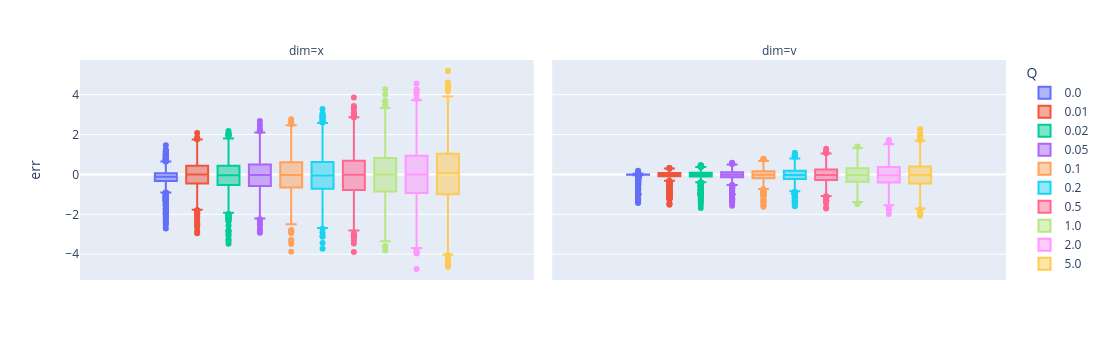

In [29]:
trace = []
for Q in [0, .01, .02, .05, .1, .2, .5, 1, 2, 5]:
    err = np.concatenate([error_fwd(simulate_kalman_2d(np.eye(2) * Q)) for _ in range(20)])
    trace.append(pd.DataFrame(dict(Q=Q, x=err[:,0], v=err[:,1])))
trace = pd.concat(trace).melt(['Q'], None, 'dim', 'err')

ex.box(trace, y='err', color='Q', facet_col='dim')

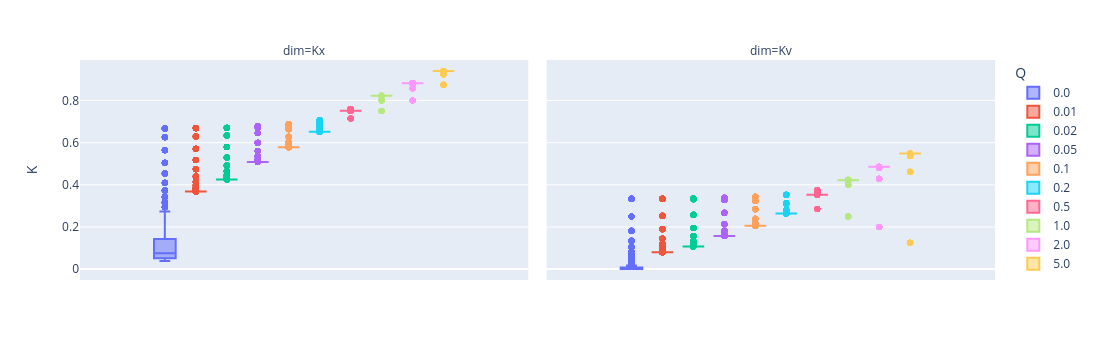

In [36]:
trace = []
for Q in [0, .01, .02, .05, .1, .2, .5, 1, 2, 5]:
    for _ in range(20):
        run = simulate_kalman_2d(np.eye(2) * Q)
        K = [np.squeeze(row[4].T) for row in run]
        K = np.array(K)
        trace.append(pd.DataFrame(dict(Q=Q, Kx=K[:,0], Kv=K[:,1])))

trace = pd.concat(trace).melt(['Q'], None, 'dim', 'K')
ex.box(trace, y='K', color='Q', facet_col='dim')

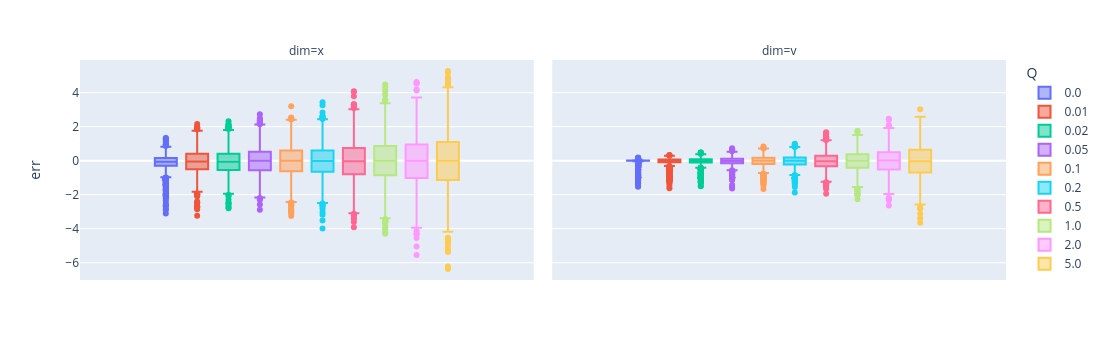

In [38]:
trace = []
for Q in [0, .01, .02, .05, .1, .2, .5, 1, 2, 5]:
    err = np.concatenate([error_fwd(simulate_kalman_2d(np.array([[1/3, 1/2], [1/2, 1]]) * Q)) for _ in range(20)])
    trace.append(pd.DataFrame(dict(Q=Q, x=err[:,0], v=err[:,1])))
trace = pd.concat(trace).melt(['Q'], None, 'dim', 'err')

ex.box(trace, y='err', color='Q', facet_col='dim')

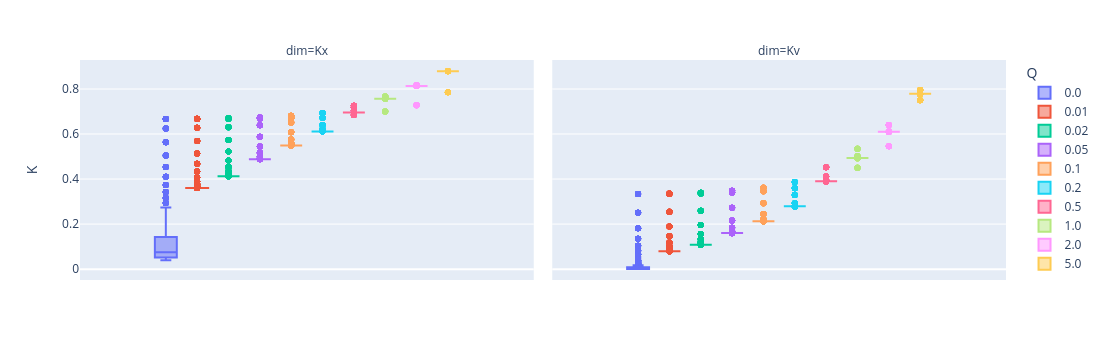

In [39]:
trace = []
for Q in [0, .01, .02, .05, .1, .2, .5, 1, 2, 5]:
    for _ in range(20):
        run = simulate_kalman_2d(np.array([[1/3, 1/2], [1/2, 1]]) * Q)
        K = [(row[4][0,0], row[4][1,0]) for row in run]
        K = np.array(K)
        trace.append(pd.DataFrame(dict(Q=Q, Kx=K[:,0], Kv=K[:,1])))

trace = pd.concat(trace).melt(id_vars=['Q'], var_name='dim', value_name='K')
ex.box(trace, y='K', color='Q', facet_col='dim')